In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd "drive/MyDrive/EAI-2223-40"

/content/drive/MyDrive/EAI_Project


In [ ]:
!pip install nilearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.3/10.3 MB 43.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 76.3 MB/s eta 0:00:00
  Attempting uninstall: nibabel
    Found existing installation: nibabel 3.0.2
    Uninstalling nibabel-3.0.2:
      Successfully uninstalled nibabel-3.0.2


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
!pip3 install -U segmentation-models
%env SM_FRAMEWORK=tf.keras
import segmentation_models as sm
import tensorflow as tf
tf.keras.backend.set_image_data_format('channels_last')
import nilearn as nl
import nibabel as nib
import nilearn.plotting as nlplt

import os
import cv2
import glob
import PIL
import shutil
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from skimage import data
from skimage.util import montage 
import skimage.transform as skTrans
from skimage.transform import rotate
from skimage.transform import resize
from PIL import Image, ImageOps  
import keras
import keras.backend as K
from keras.callbacks import CSVLogger
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, TensorBoard
from tensorflow.keras.layers.experimental import preprocessing
np.set_printoptions(precision=3, suppress=True)



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 6.0 MB/s eta 0:00:00
env: SM_FRAMEWORK=tf.keras
Segmentation Models: using `tf.keras` framework.


In [ ]:
# Define segmentation areas
areas = {
    0: 'Non-tumor',
    1: 'Necrotic/core',
    2: 'Edema',
    3: 'Enhancing' # originally 4, converted to 3 later
}

# Each volume contains 155 slices, but we'll use 100 slices starting from slice 22
num_slices = 100
start_slice = 22

In [ ]:
inv_class_dict = {v: k for k, v in areas.items()}


In [ ]:
TRAIN_DATASET_PATH = 'BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/'
VALIDATION_DATASET_PATH = 'BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData'


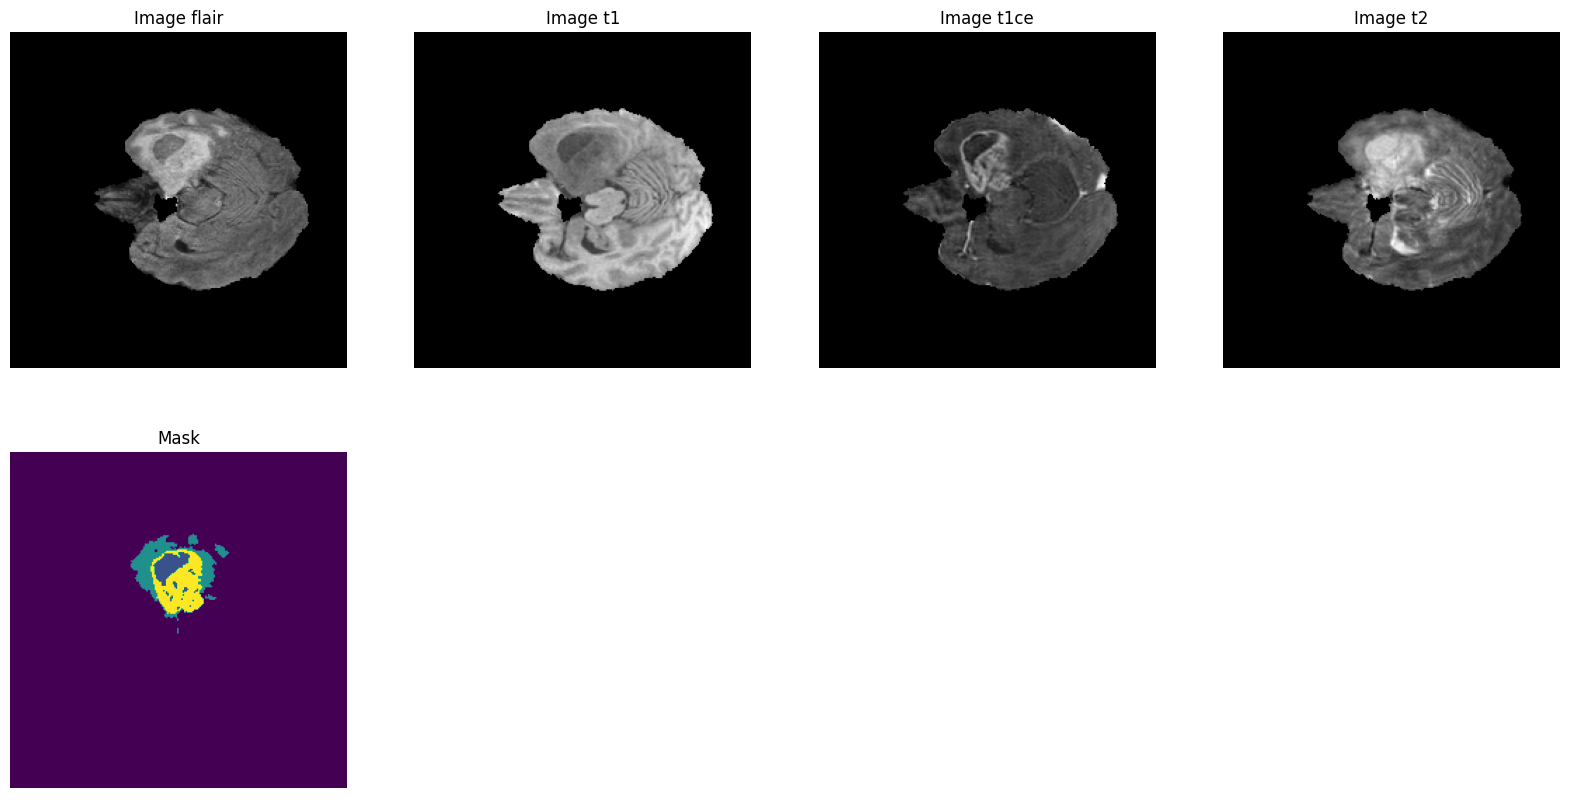

In [ ]:
# Set data paths
data_dir = os.path.join(os.getcwd(), 'BraTS2020_TrainingData', 'MICCAI_BraTS2020_TrainingData')
subject_id = 'BraTS20_Training_001'
subject_dir = os.path.join(data_dir, subject_id)

# Load image and mask data
images = {}
for modality in ['flair', 't1', 't1ce', 't2']:
    image_file = os.path.join(subject_dir, f"{subject_id}_{modality}.nii")
    images[modality] = nib.load(image_file).get_fdata()

mask_file = os.path.join(subject_dir, f"{subject_id}_seg.nii")
mask = nib.load(mask_file).get_fdata()

# Plot image and mask slices
fig, axs = plt.subplots(2, 4, figsize=(20, 10))
slice_w = 25
for i, modality in enumerate(images):
    axs[0, i].imshow(images[modality][:, :, images[modality].shape[2] // 2 - slice_w], cmap='gray')
    axs[0, i].set_title(f"Image {modality}")

axs[1, 0].imshow(mask[:, :, mask.shape[2] // 2 - slice_w])
axs[1, 0].set_title("Mask")

for ax in axs.flatten():
    ax.axis('off')

plt.show()

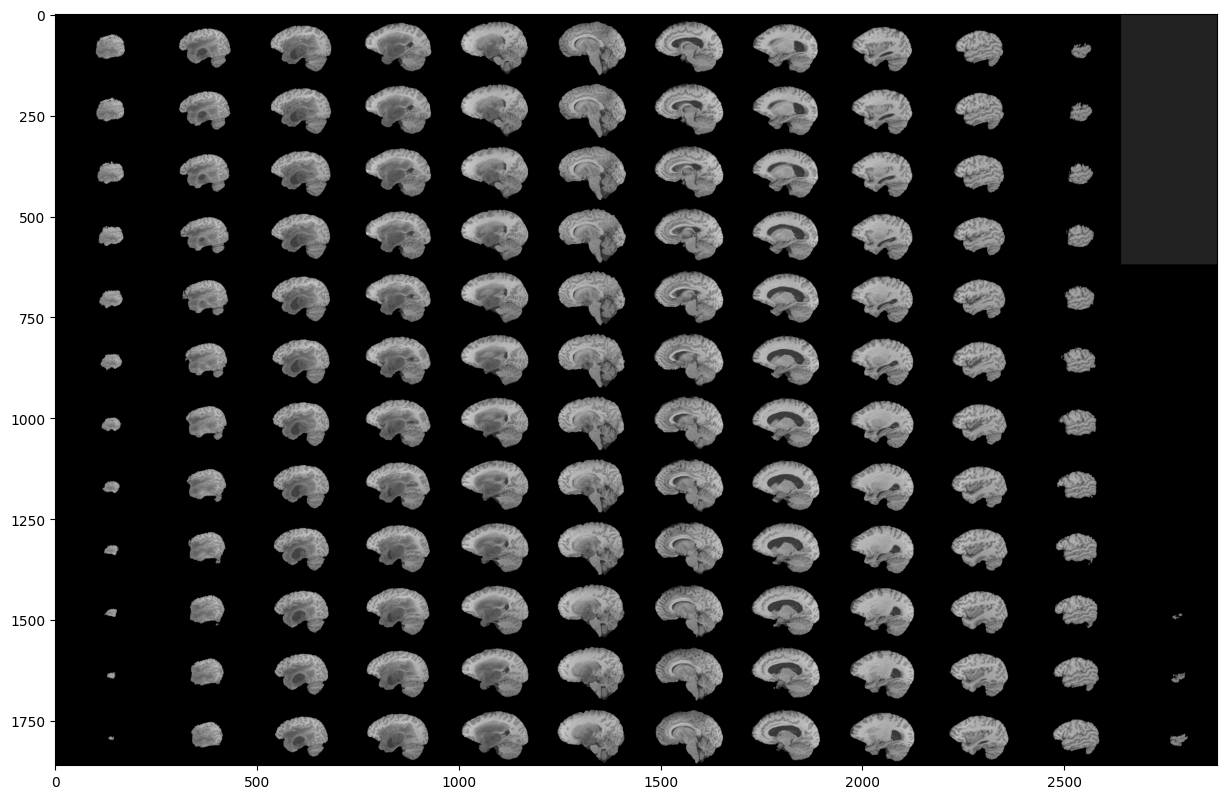

In [ ]:
# Skip 50:-50 slices since there is not much to see
fig, ax1 = plt.subplots(1, 1, figsize = (15,15))
ax1.imshow(rotate(montage(test_image_t1[50:-50,:,:]), 90, resize=True), cmap ='gray')

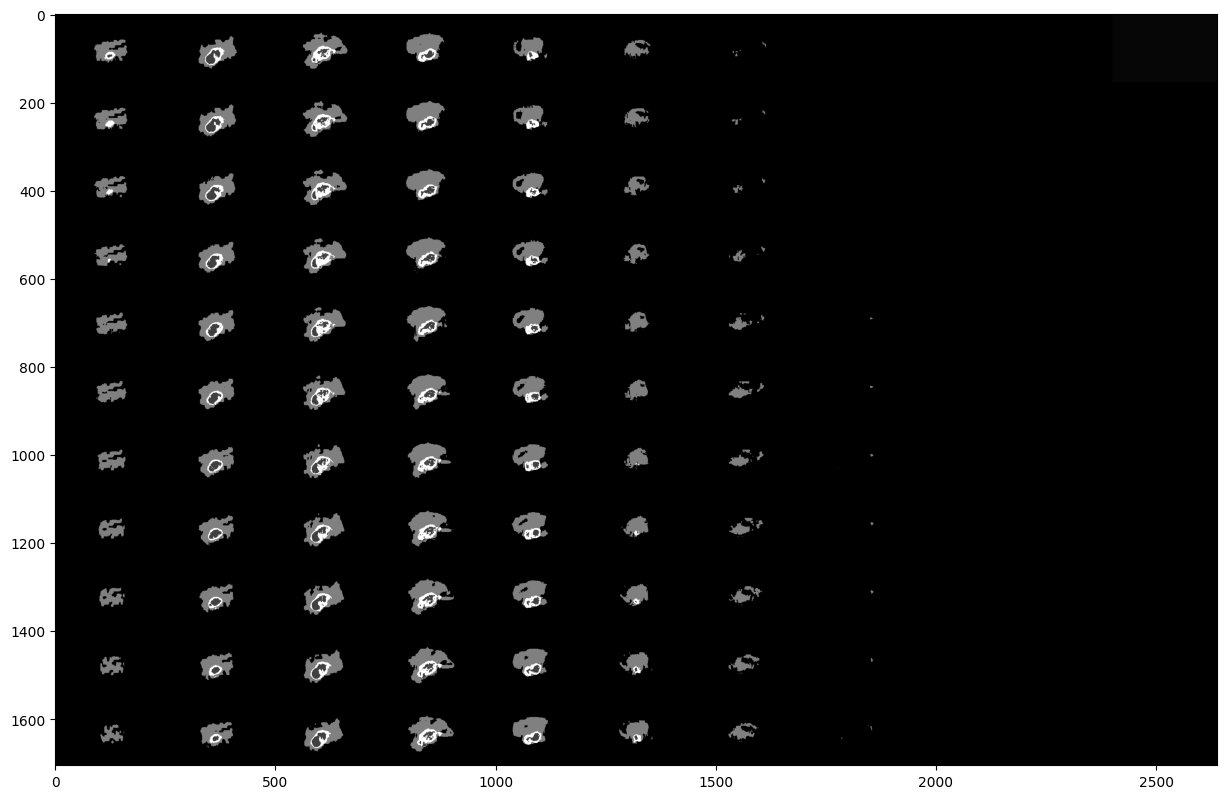

In [ ]:
# Skip 50:-50 slices since there is not much to see
fig, ax1 = plt.subplots(1, 1, figsize = (15,15))
ax1.imshow(rotate(montage(test_mask[60:-60,:,:]), 90, resize=True), cmap ='gray')

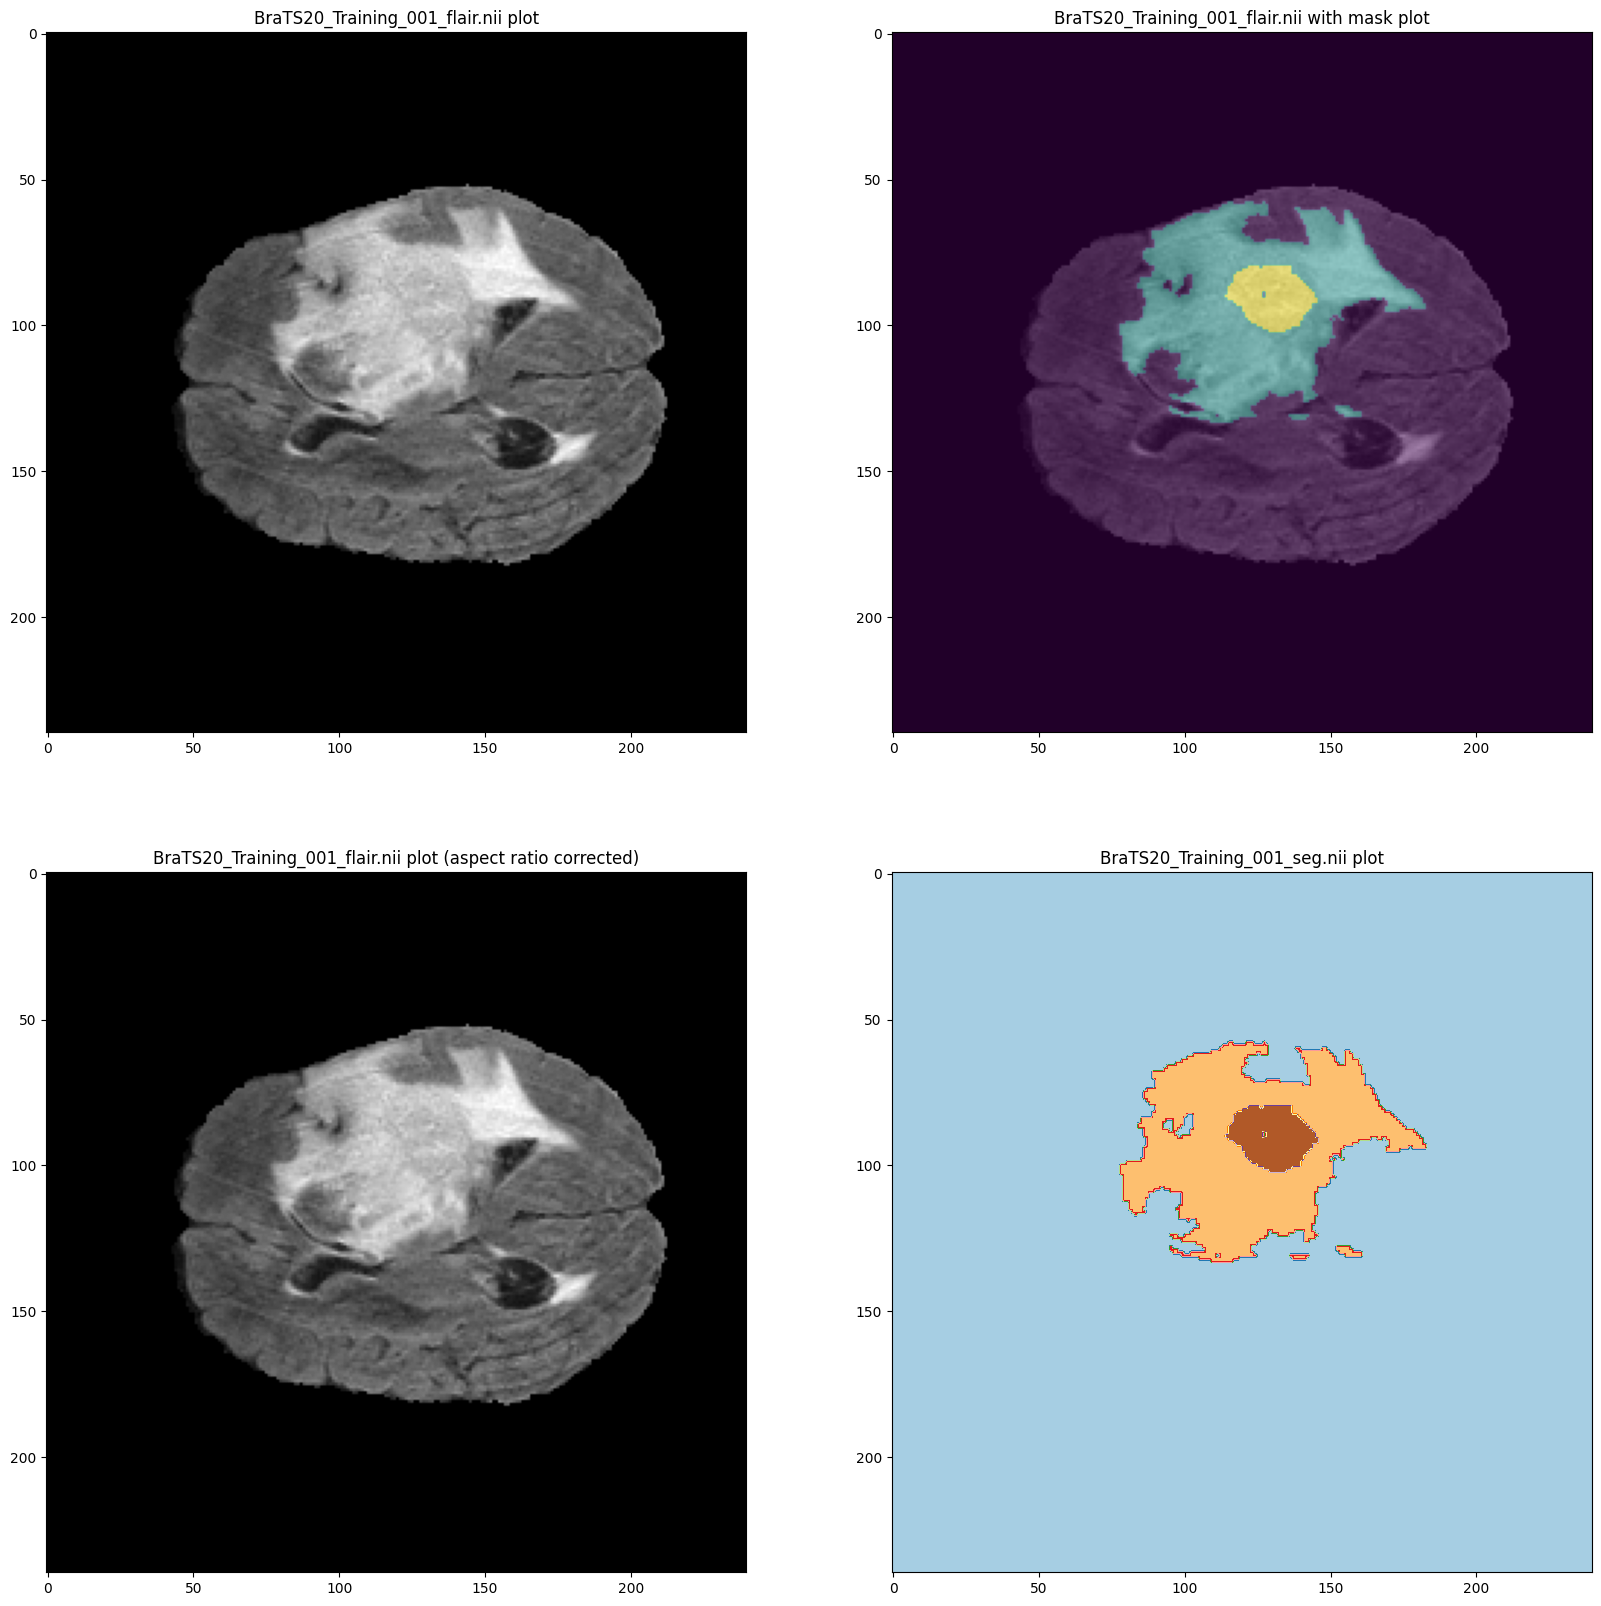

In [ ]:
niimg = nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_flair.nii')
nimask = nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_seg.nii')

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 20))

axes[0, 0].imshow(niimg.get_fdata()[:,:,niimg.shape[2]//2], cmap='gray')
axes[0, 0].set_title('BraTS20_Training_001_flair.nii plot')

axes[0, 1].imshow(niimg.get_fdata()[:,:,niimg.shape[2]//2], cmap='gray')
axes[0, 1].imshow(nimask.get_fdata()[:,:,nimask.shape[2]//2], alpha=0.5)
axes[0, 1].set_title('BraTS20_Training_001_flair.nii with mask plot')

axes[1, 0].imshow(niimg.get_fdata()[:,:,niimg.shape[2]//2], cmap='gray', aspect=niimg.header['pixdim'][1]/niimg.header['pixdim'][2])
axes[1, 0].set_title('BraTS20_Training_001_flair.nii plot (aspect ratio corrected)')

axes[1, 1].imshow(nimask.get_fdata()[:,:,nimask.shape[2]//2], cmap='Paired')
axes[1, 1].set_title('BraTS20_Training_001_seg.nii plot')

plt.show()


In [ ]:
# dice loss as defined above for 4 classes
def dice_coef(y_true, y_pred, smooth=1.0):
    class_num = 4
    for i in range(class_num):
        y_true_f = K.flatten(y_true[:,:,:,i])
        y_pred_f = K.flatten(y_pred[:,:,:,i])
        intersection = K.sum(y_true_f * y_pred_f)
        loss = ((2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth))
   
        if i == 0:
            total_loss = loss
        else:
            total_loss = total_loss + loss
    total_loss = total_loss / class_num
    return total_loss


 
# we define dice coeffienct for each class seperately
# referenced from https://github.com/keras-team/keras/issues/9395
def dice_coef_necrotic(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,1] * y_pred[:,:,:,1]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,1])) + K.sum(K.square(y_pred[:,:,:,1])) + epsilon)

def dice_coef_edema(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,2] * y_pred[:,:,:,2]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,2])) + K.sum(K.square(y_pred[:,:,:,2])) + epsilon)

def dice_coef_enhancing(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,3] * y_pred[:,:,:,3]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,3])) + K.sum(K.square(y_pred[:,:,:,3])) + epsilon)



def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

    
def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())


def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

In [ ]:
IMG_SIZE=128

In [ ]:

# source https://naomi-fridman.medium.com/multi-class-image-segmentation-a5cc671e647a

def build_unet(inputs, ker_init, dropout):
    conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(inputs)
    conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv1)
    
    pool = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool)
    conv = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv)
    
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv2)
    
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv3)
    
    
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv5 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool4)
    conv5 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv5)
    drop5 = Dropout(dropout)(conv5)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = (2,2))(drop5))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv9)
    
    up = Conv2D(32, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = (2,2))(conv9))
    merge = concatenate([conv1,up], axis = 3)
    conv = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge)
    conv = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv)
    
    conv10 = Conv2D(4, (1,1), activation = 'softmax')(conv)
    
    return Model(inputs = inputs, outputs = conv10)

input_layer = Input((IMG_SIZE, IMG_SIZE, 2))

model = build_unet(input_layer, 'he_normal', 0.2)
model.compile(loss="categorical_crossentropy", optimizer=keras.optimizers.Adam(learning_rate=0.001), metrics = ['accuracy',tf.keras.metrics.MeanIoU(num_classes=4), dice_coef, precision, sensitivity, specificity, dice_coef_necrotic, dice_coef_edema ,dice_coef_enhancing] )

In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 128, 128, 2  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_19 (Conv2D)             (None, 128, 128, 32  608         ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_20 (Conv2D)             (None, 128, 128, 32  9248        ['conv2d_19[0][0]']              
                                )                                                           

In [ ]:
# Get a list of directories with studies, excluding one with ill-formatted name
train_and_val_directories = []
for f in os.scandir(TRAIN_DATASET_PATH):
    if f.is_dir() and os.path.basename(f.path) != 'BraTS20_Training_355':
        train_and_val_directories.append(f.path)

# Convert directory paths to study IDs
train_and_test_ids = [os.path.basename(path) for path in train_and_val_directories]

# Split the study IDs into train, validation, and test sets
train_test_ids, val_ids = train_test_split(train_and_test_ids,test_size=0.2) 
train_ids, test_ids = train_test_split(train_test_ids,test_size=0.15) 


In [ ]:
print(len(train_ids))
print(len(val_ids))
print(len(test_ids))

249
74
45


In [ ]:
class DataGenerator(keras.utils.Sequence):
    def __init__(self, list_IDs, dim=(IMG_SIZE, IMG_SIZE), batch_size=1, n_channels=2, shuffle=True):
        self.dim = dim
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.indexes = np.arange(len(list_IDs))
        self.on_epoch_end()

    def __len__(self):
        return len(self.list_IDs) // self.batch_size

    def __getitem__(self, index):
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        IDs = [self.list_IDs[k] for k in indexes]
        X, y = self.__data_generation(IDs)
        return X, y

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __data_generation(self, IDs):
        X = np.zeros((self.batch_size*num_slices, *self.dim, self.n_channels))
        y = np.zeros((self.batch_size*num_slices, 240, 240))
        Y = np.zeros((self.batch_size*num_slices, *self.dim, 4))

        for i, ID in enumerate(IDs):
            case_path = os.path.join(TRAIN_DATASET_PATH, ID)
            flair = nib.load(os.path.join(case_path, f'{ID}_flair.nii')).get_fdata()
            ce = nib.load(os.path.join(case_path, f'{ID}_t1ce.nii')).get_fdata()
            seg = nib.load(os.path.join(case_path, f'{ID}_seg.nii')).get_fdata()

            for j in range(num_slices):
                X[j + num_slices*i, :, :, 0] = cv2.resize(flair[:, :, j+start_slice], (IMG_SIZE, IMG_SIZE))
                X[j + num_slices*i, :, :, 1] = cv2.resize(ce[:, :, j+start_slice], (IMG_SIZE, IMG_SIZE))
                y[j + num_slices*i] = seg[:, :, j+start_slice]

        y[y==4] = 3
        y_resized = np.zeros((self.batch_size*num_slices, IMG_SIZE, IMG_SIZE))
        for j in range(y.shape[0]):
            y_resized[j,:,:] = cv2.resize(y[j,:,:], (IMG_SIZE, IMG_SIZE))
        mask = tf.one_hot(y_resized, 4)
        Y = mask

        return X / np.max(X), Y


In [ ]:
train_generator = DataGenerator(train_ids)
valid_generator = DataGenerator(val_ids)


In [ ]:
callbacks = [
    keras.callbacks.EarlyStopping(
        monitor='loss', min_delta=0, patience=2, verbose=1, mode='auto'),
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss', factor=0.2, patience=2, min_lr=0.000001, verbose=1),
    keras.callbacks.ModelCheckpoint(
        filepath='modelchck/model_.{epoch:02d}-{val_loss:.6f}.m5',
        verbose=1, save_best_only=True, save_weights_only=True),
    CSVLogger('trainingLogs.log', separator=',', append=False)
]

In [ ]:
'''history =  model.fit(train_generator,
                     epochs=40,
                     steps_per_epoch=len(train_ids),
                     callbacks= callbacks,
                     validation_data = valid_generator
                     )  '''
'model.save("UnetModel.h5")'

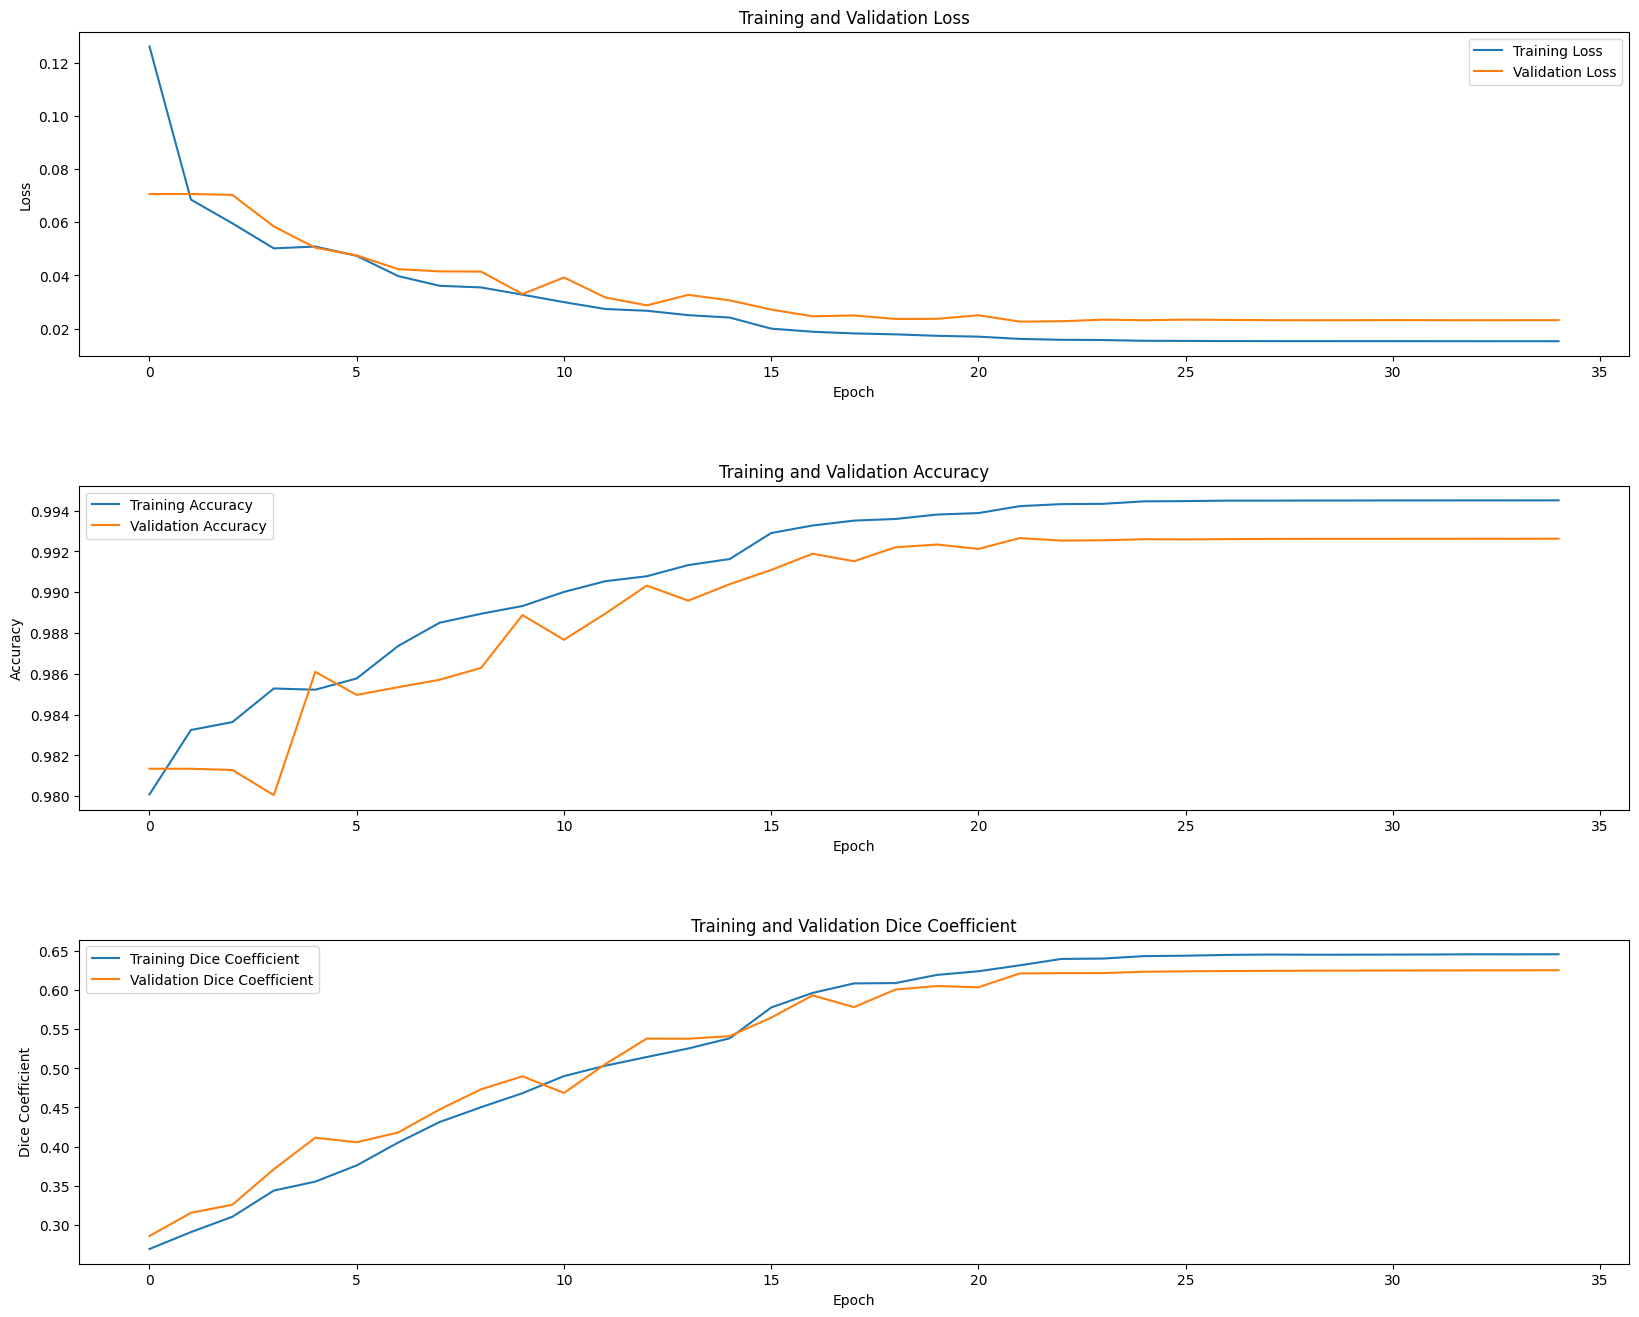

In [ ]:
############ load trained model ################
model = keras.models.load_model('UnetModel.h5', 
                                   custom_objects={ 'accuracy' : tf.keras.metrics.MeanIoU(num_classes=4),
                                                   "dice_coef": dice_coef,
                                                   "precision": precision,
                                                   "sensitivity":sensitivity,
                                                   "specificity":specificity,
                                                   "dice_coef_necrotic": dice_coef_necrotic,
                                                   "dice_coef_edema": dice_coef_edema,
                                                   "dice_coef_enhancing": dice_coef_enhancing
                                                  }, compile=False)

history = pd.read_csv('trainingLogs.log', sep=',', engine='python')

hist=history

fig, axs = plt.subplots(3, figsize=(20, 16))
plt.subplots_adjust(wspace=0.2, hspace=0.4)

axs[0].plot(hist['loss'], label='Training Loss')
axs[0].plot(hist['val_loss'], label='Validation Loss')
axs[0].set_title('Training and Validation Loss')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].legend()

axs[1].plot(hist['accuracy'], label='Training Accuracy')
axs[1].plot(hist['val_accuracy'], label='Validation Accuracy')
axs[1].set_title('Training and Validation Accuracy')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy')
axs[1].legend()

axs[2].plot(hist['dice_coef'], label='Training Dice Coefficient')
axs[2].plot(hist['val_dice_coef'], label='Validation Dice Coefficient')
axs[2].set_title('Training and Validation Dice Coefficient')
axs[2].set_xlabel('Epoch')
axs[2].set_ylabel('Dice Coefficient')
axs[2].legend()

plt.show()


In [ ]:
def predictByPath(case_path,case):
    files = next(os.walk(case_path))[2]
    X = np.empty((num_slices, IMG_SIZE, IMG_SIZE, 2))
  #  y = np.empty((VOLUME_SLICES, IMG_SIZE, IMG_SIZE))
    
    vol_path = os.path.join(case_path, f'BraTS20_Training_{case}_flair.nii');
    flair=nib.load(vol_path).get_fdata()
    
    vol_path = os.path.join(case_path, f'BraTS20_Training_{case}_t1ce.nii');
    ce=nib.load(vol_path).get_fdata() 
    
 #   vol_path = os.path.join(case_path, f'BraTS20_Training_{case}_seg.nii');
 #   seg=nib.load(vol_path).get_fdata()  

    
    for j in range(num_slices):
        X[j,:,:,0] = cv2.resize(flair[:,:,j+start_slice], (IMG_SIZE,IMG_SIZE))
        X[j,:,:,1] = cv2.resize(ce[:,:,j+start_slice], (IMG_SIZE,IMG_SIZE))
 #       y[j,:,:] = cv2.resize(seg[:,:,j+VOLUME_START_AT], (IMG_SIZE,IMG_SIZE))
        
    #model.evaluate(x=X,y=y[:,:,:,0], callbacks= callbacks)
    return model.predict(X/np.max(X), verbose=1)


def showPredictsById(case, slicestrt = 60):
    path = f"BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_{case}"
    gt = nib.load(os.path.join(path, f'BraTS20_Training_{case}_seg.nii')).get_fdata()
    origImage = nib.load(os.path.join(path, f'BraTS20_Training_{case}_flair.nii')).get_fdata()
    p = predictByPath(path,case)
    #print(p.shape)
    core = p[:,:,:,1]

    edema= p[:,:,:,2]
    enhancing = p[:,:,:,3]

    

    plt.figure(figsize=(18, 50))
    f, axarr = plt.subplots(1,6, figsize = (18, 50)) 

    for i in range(6): # for each image, add brain background
        axarr[i].imshow(cv2.resize(origImage[:,:,slicestrt+start_slice], (IMG_SIZE, IMG_SIZE)), cmap="gray", interpolation='none')
    
    axarr[0].imshow(cv2.resize(origImage[:,:,slicestrt+start_slice], (IMG_SIZE, IMG_SIZE)), cmap="gray")
    axarr[0].title.set_text('Original image flair')
    curr_gt=cv2.resize(gt[:,:,slicestrt+start_slice], (IMG_SIZE, IMG_SIZE), interpolation = cv2.INTER_NEAREST)
    axarr[1].imshow(curr_gt, cmap="Reds", interpolation='none', alpha=0.3) # ,alpha=0.3,cmap='Reds'
    axarr[1].title.set_text('Ground truth')
    axarr[2].imshow(p[slicestrt,:,:,1:4], cmap="Reds", interpolation='none', alpha=0.3)
    #print(p[start_slice,:,:,1:4].shape)
    axarr[2].title.set_text('all classes')
    axarr[3].imshow(edema[slicestrt,:,:], cmap="OrRd", interpolation='none', alpha=0.3)
    axarr[3].title.set_text(f'{areas[1]} predicted')
    axarr[4].imshow(core[slicestrt,:,], cmap="OrRd", interpolation='none', alpha=0.3)
    axarr[4].title.set_text(f'{areas[2]} predicted')
    axarr[5].imshow(enhancing[slicestrt,:,], cmap="OrRd", interpolation='none', alpha=0.3)
    axarr[5].title.set_text(f'{areas[3]} predicted')
    plt.show()
    


4/4 [==============================] - 17s 4s/step


<Figure size 1800x5000 with 0 Axes>

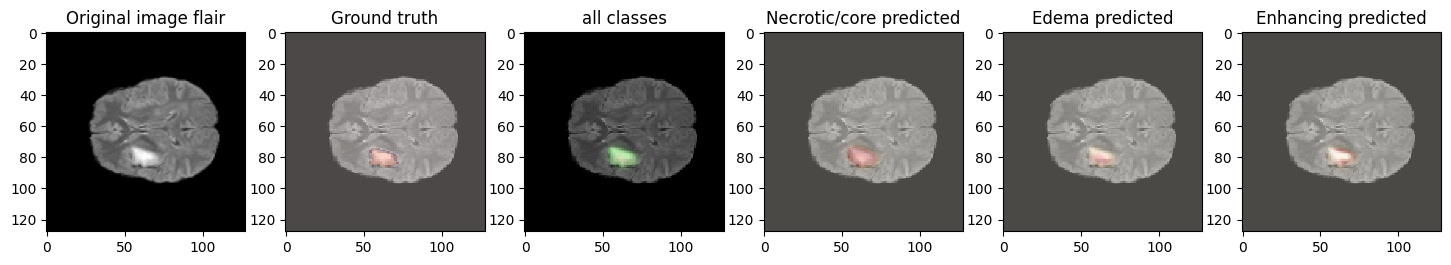

In [ ]:
showPredictsById(case=test_ids[0][-3:])

4/4 [==============================] - 0s 61ms/step


<Figure size 1800x5000 with 0 Axes>

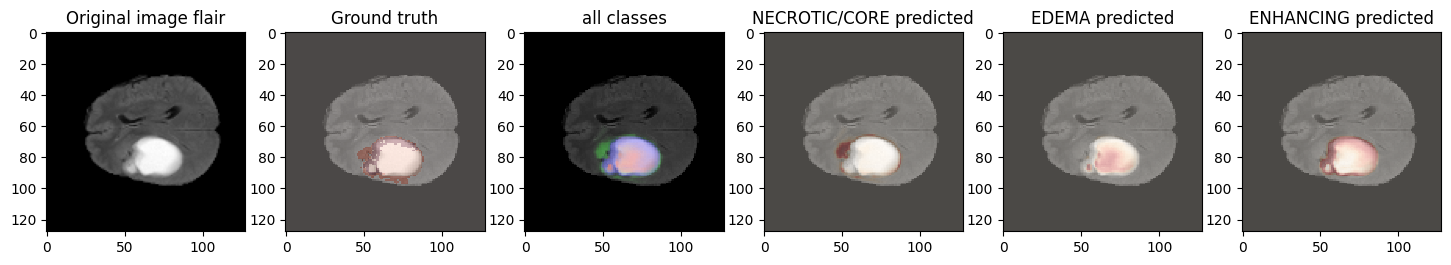

In [ ]:
showPredictsById(case=test_ids[1][-3:])


4/4 [==============================] - 0s 67ms/step


<Figure size 1800x5000 with 0 Axes>

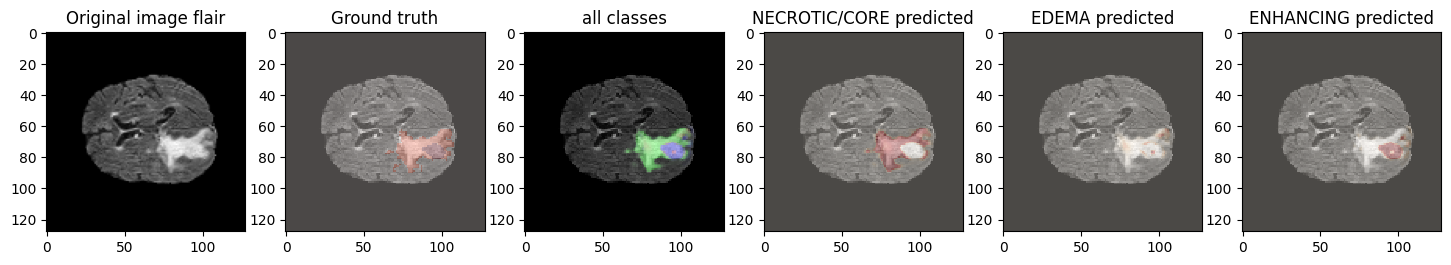

In [ ]:
showPredictsById(case=test_ids[2][-3:])


4/4 [==============================] - 0s 69ms/step


<Figure size 1800x5000 with 0 Axes>

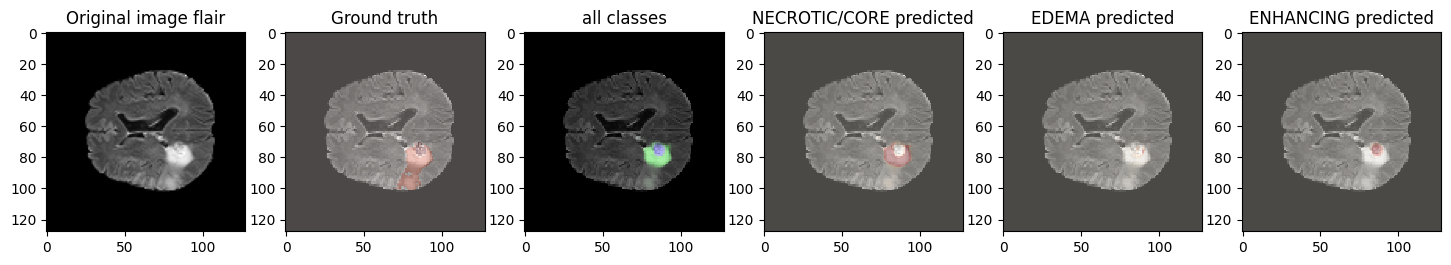

In [ ]:
showPredictsById(case=test_ids[15][-3:])


4/4 [==============================] - 0s 69ms/step


<Figure size 1800x5000 with 0 Axes>

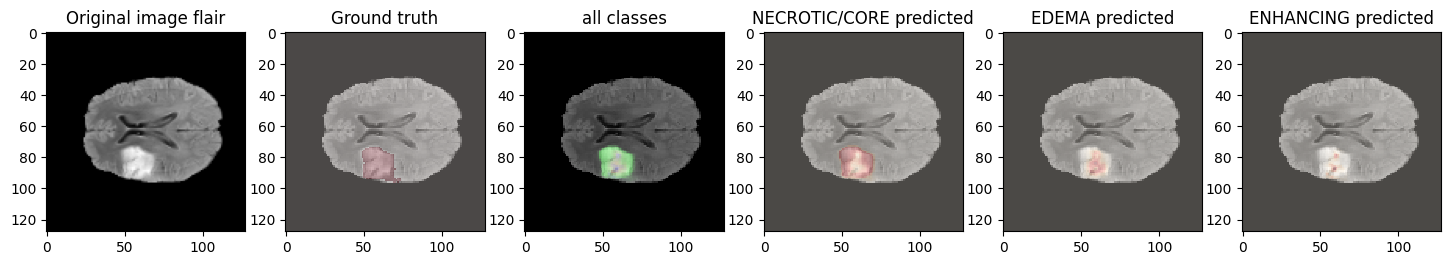

In [ ]:
showPredictsById(case=test_ids[4][-3:])


4/4 [==============================] - 0s 69ms/step


<Figure size 1800x5000 with 0 Axes>

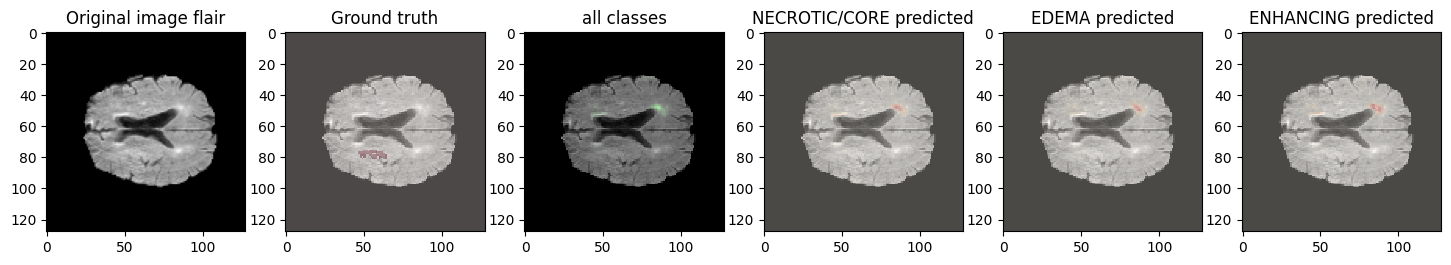

In [ ]:
showPredictsById(case=test_ids[5][-3:])


4/4 [==============================] - 0s 66ms/step


<Figure size 1800x5000 with 0 Axes>

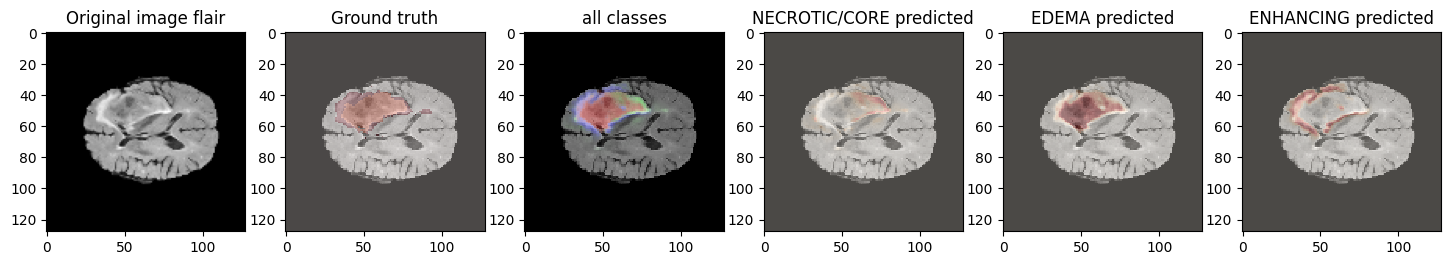

In [ ]:
showPredictsById(case=test_ids[6][-3:])


4/4 [==============================] - 0s 69ms/step


<Figure size 1800x5000 with 0 Axes>

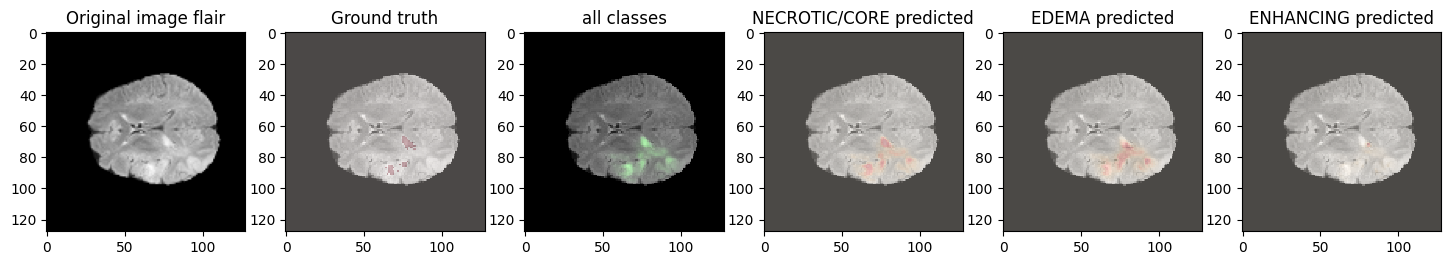

In [ ]:
showPredictsById(case=test_ids[7][-3:])

4/4 [==============================] - 0s 61ms/step


<Figure size 1800x5000 with 0 Axes>

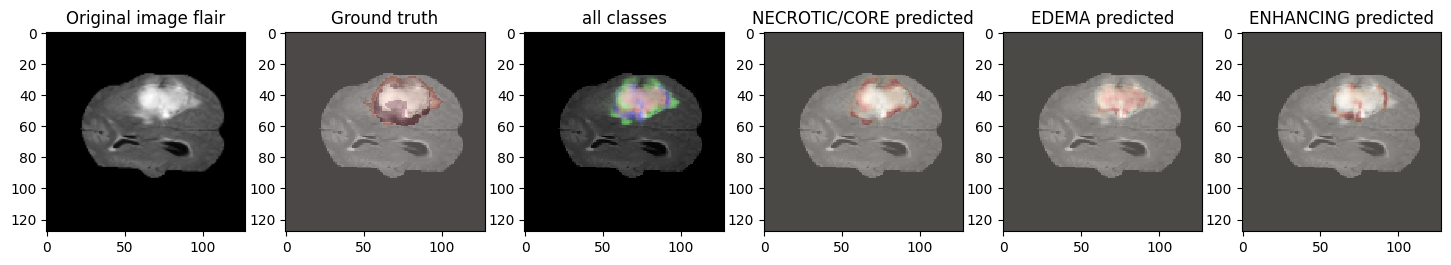

In [ ]:
showPredictsById(case=test_ids[8][-3:])


In [ ]:
test_generator=DataGenerator(test_ids)

In [ ]:
model.compile(loss="categorical_crossentropy", optimizer=keras.optimizers.Adam(learning_rate=0.001), metrics = ['accuracy',tf.keras.metrics.MeanIoU(num_classes=4), dice_coef, precision, sensitivity, specificity, dice_coef_necrotic, dice_coef_edema, dice_coef_enhancing] )
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(test_generator, batch_size=100, callbacks= callbacks)
print("test loss, test acc:", results)

Evaluate on test data
45/45 [==============================] - 828s 18s/step - loss: 0.0230 - accuracy: 0.9927 - mean_io_u_5: 0.3750 - dice_coef: 0.5975 - precision: 0.9938 - sensitivity: 0.9921 - specificity: 0.9979 - dice_coef_necrotic: 0.4369 - dice_coef_edema: 0.7056 - dice_coef_enhancing: 0.5858
test loss, test acc: [0.023001179099082947, 0.9927429556846619, 0.375, 0.5974993109703064, 0.9937547445297241, 0.9920910596847534, 0.9979232549667358, 0.43686267733573914, 0.7056334018707275, 0.585825502872467]
